<a href="https://colab.research.google.com/github/jasonhadiputra/option-pricing/blob/master/PMK.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
from numpy.lib.stride_tricks import sliding_window_view
import pandas as pd

from scipy.stats import norm

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

import requests

In [ ]:
# from google.colab import drive
# drive.mount('/gdrive')
# %cd "/gdrive/MyDrive/Learn/Projects/3261MA Intro to Financial Mathematics"

In [ ]:
def option_payout(option_type, stock_price, strike_price):
    if option_type.lower() == 'call':
        return np.where(stock_price > strike_price, stock_price-strike_price, 0)
    elif option_type.lower() == 'put':
        return np.where(stock_price < strike_price, strike_price-stock_price, 0)
    else:
        raise ValueError('Option type must be either call or put')

# Data

In [ ]:
unix_start_date = np.datetime64('2018-01-31', 's').astype('int')
unix_end_date = np.datetime64('2023-02-28', 's').astype('int')

url = f'https://finance.yahoo.com/quote/AAPL/history'
params = {
    'period1': unix_start_date.astype('str'),
    'period2': unix_end_date.astype('str'),
    'interval': '1mo',
    'filter': 'history',
    'frequency': '1mo',
    'includeAdjustedClose': 'true',
}
headers = {'User-Agent': 'Custom'}

data = requests.get(url, params=params, headers=headers).text

df = (
    pd.read_html(data, index_col='Date')[0]
    # Exclude dividends and invalid data
    .loc[
        lambda df: df['Adj Close**'].str.contains(r'[0-9]$', regex='True'),
        ['Adj Close**']
    ]
    .rename(index=pd.to_datetime, columns={"Adj Close**": 'AAPL'})        
    .sort_index()
    .astype('float')
)

df

,AAPL
Date,
2018-02-01,42.28
2018-03-01,39.99
2018-04-01,39.39
2018-05-01,44.54
2018-06-01,44.29
...,...
2022-10-01,152.85
2022-11-01,147.56
2022-12-01,129.73


In [ ]:
df_return = (
    df.apply(np.log)
    .diff()
    .dropna()
)

df_return

,AAPL
Date,
2018-03-01,-0.055685
2018-04-01,-0.015117
2018-05-01,0.122876
2018-06-01,-0.005629
2018-07-01,0.027613
2018-08-01,0.179095
2018-09-01,-0.004786
2018-10-01,-0.030916
2018-11-01,-0.203593


In [ ]:
delta_t = 1/12  # year

drift = df_return['AAPL'].mean() / delta_t
rate = df_return['AAPL'].mean() / delta_t + df_return['AAPL'].var()/2
volatility = df_return['AAPL'].std() / np.sqrt(delta_t)
r = 0.04  #! temporary, change if better estimate found

print(f"{(drift,rate,volatility,r)=}")

(drift,rate,volatility,r)=(0.2494820216404918, 0.2537628817087337, 0.3205318106488107, 0.04)


In [ ]:
df_option = pd.DataFrame({
    'ID': ['AAPL230414P00150000', 'AAPL230414C00160000', 'AAPL230414C00170000'],
    'Type': ['Put','Call','Call'],
    'K': [150, 160, 170],
    'Actual': [3.91, 1.98, 0.260]
})

df_option

,ID,Type,K,Actual
0,AAPL230414P00150000,Put,150,3.91
1,AAPL230414C00160000,Call,160,1.98
2,AAPL230414C00170000,Call,170,0.26


# Binomial Tree

In [ ]:
def binomial_tree(step, init, u, d):
    binomial_tree = [np.array([init], dtype='float')]

    for i in range(step):
        prev = binomial_tree[-1]
        # Multiply all elements by u
        # Multiply only last element by d
        binomial_tree.append(np.append(u*prev, prev[-1]*d))

    return binomial_tree

df_option

,ID,Type,K,Actual
0,AAPL230414P00150000,Put,150,3.91
1,AAPL230414C00160000,Call,160,1.98
2,AAPL230414C00170000,Call,170,0.26


In [ ]:
N = 12000  # N steps in 1 year
init = 152.59  # Stock price on March 14th 2023

delta_t = 1 / N
v = np.exp(-r*delta_t)

u = v**-1 * (1 + np.sqrt(np.exp(volatility**2*delta_t)-1))
d = v**-1 * (1 - np.sqrt(np.exp(volatility**2*delta_t)-1))
p = 1/2

for period in [1/12,3/12,6/12]:
    stock_binomial_tree = binomial_tree(int(N * period), init, u, d)

    for option_index, ser in df_option.iterrows():
        option_type = ser['Type']
        strike_price = ser['K']

        option_binomial_tree = []
        option_binomial_tree.append(
            option_payout(option_type, stock_binomial_tree[-1], strike_price)
        )

        for _ in range(len(stock_binomial_tree[-1])-1):
            last_option_prices = option_binomial_tree[-1]
            expected_option_price = (
                sliding_window_view(last_option_prices, 2) @ np.array([p, 1-p])
            )
            option_binomial_tree.append(v * expected_option_price)

        option_binomial_tree = option_binomial_tree[::-1]

        df_option.at[option_index, f'Binomial {period}'] = option_binomial_tree[0]

In [ ]:
df_option

,ID,Type,K,Actual,Binomial 0.08333333333333333,Binomial 0.25,Binomial 0.5
0,AAPL230414P00150000,Put,150,3.91,4.165244,7.711893,10.916598
1,AAPL230414C00160000,Call,160,1.98,2.960229,7.292117,11.939594
2,AAPL230414C00170000,Call,170,0.26,0.958292,4.241996,8.447633


# GBM

In [ ]:
N = 12000  # N steps in 1 year
init = 152.59  # Stock price on March 14th 2023
n_sim = 1000

delta_t = 1 / N
v = np.exp(-r)

np.random.seed(42)
norm_rv = norm(drift * delta_t, volatility * np.sqrt(delta_t))

for period in [1/12,3/12,6/12]:
    for option_index, ser in df_option.iterrows():
        option_type = ser['Type']
        strike_price = ser['K']

        random_samples = norm_rv.rvs((n_sim, int(N * period)))
        stock_prices = init * np.exp(np.sum(random_samples, axis=1))

        option_price = v**period * np.mean(
            option_payout(option_type, stock_prices, strike_price)
        )

        df_option.at[option_index, f'GBM {period}'] = option_price

In [ ]:
df_option

,ID,Type,K,Actual,Binomial 0.08333333333333333,Binomial 0.25,Binomial 0.5,GBM 0.08333333333333333,GBM 0.25,GBM 0.5
0,AAPL230414P00150000,Put,150,3.91,4.165244,7.711893,10.916598,3.314321,4.378422,4.607018
1,AAPL230414C00160000,Call,160,1.98,2.960229,7.292117,11.939594,4.115801,12.819671,24.357926
2,AAPL230414C00170000,Call,170,0.26,0.958292,4.241996,8.447633,1.320115,7.448935,18.549767


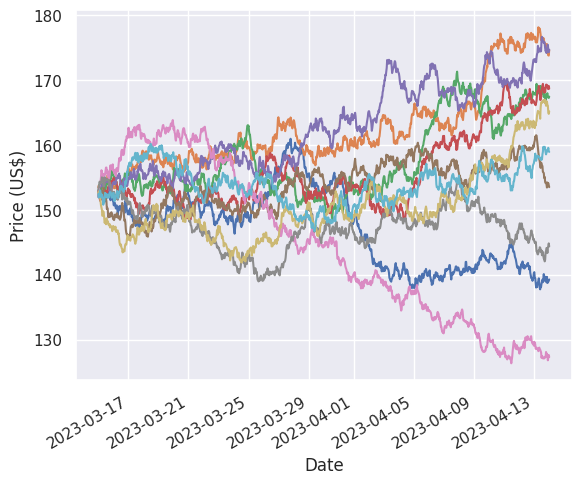

In [ ]:
random_samples = norm_rv.rvs((10, int(N * 1/12)))

x = pd.date_range('2023-03-15', '2023-04-14', periods=int(N * 1/12))
y = init * np.exp(np.cumsum(random_samples, axis=1))

plt.plot(x,y.T)
plt.xticks(rotation=30, ha='right')

plt.xlabel("Date")
plt.ylabel("Price (US$)")

plt.show()

# Black-Scholes

In [ ]:
def bs_price(option_type, strike_price, r,
             init_stock_price, volatility, period):
    quantiles = np.array([(r + volatility**2 / 2) * period,
                          (r - volatility**2 / 2) * period])
    
    quantiles += np.log(init_stock_price/strike_price)
    quantiles /= (volatility*np.sqrt(period))

    if option_type.lower() == 'call':
        probabilities = norm.cdf(quantiles)
        option_price = init_stock_price * probabilities[0]
        option_price -= strike_price * np.exp(-r*period) * probabilities[1]
        return option_price
    elif option_type.lower() == 'put':
        probabilities = norm.cdf(-quantiles)
        option_price = strike_price * np.exp(-r*period) * probabilities[1]
        option_price -= init_stock_price * probabilities[0]
        return option_price
    else:
        raise ValueError('option_type must be put or call')

In [ ]:
init = 152.59

for period in [1/12,3/12,6/12]:
    for option_index, ser in df_option.iterrows():
        option_type = ser['Type']
        strike_price = ser['K']

        option_price = bs_price(option_type, strike_price, r,
                            init, volatility, period)
        
        df_option.at[option_index, f'BS {period}'] = option_price

In [ ]:
df_option

,ID,Type,K,Actual,Binomial 0.08333333333333333,Binomial 0.25,Binomial 0.5,GBM 0.08333333333333333,GBM 0.25,GBM 0.5,BS 0.08333333333333333,BS 0.25,BS 0.5
0,AAPL230414P00150000,Put,150,3.91,4.165244,7.711893,10.916598,3.314321,4.378422,4.607018,4.164617,7.711086,10.916898
1,AAPL230414C00160000,Call,160,1.98,2.960229,7.292117,11.939594,4.115801,12.819671,24.357926,2.959638,7.291362,11.939814
2,AAPL230414C00170000,Call,170,0.26,0.958292,4.241996,8.447633,1.320115,7.448935,18.549767,0.957975,4.242524,8.447109
